# 特征选择

当数据集包含很多特征，例如超过100个，该如何处理？

有的特征可能是噪音，没有预测能力，部分特征之间可能高度相关，如果把所有数据喂到机器学习算法，会导致糟糕的结果：

1. 预测精度低，这点容易理解，即所谓垃圾进垃圾出(garbage in, garbage out)
2. 低泛化能力
3. 模型训练的时间更长

为了解决这个问题，需要使用特征选择(feature selection).

**所谓特征选择，即根据某个标准，从众多特征中挑选出预测能力最强的特征**。

有四种常用的方法，sklearn提供了相应的实现接口：

1. 单变量选择
2. 递归消除
3. 特征重要性
4. PCA

参考教程：

* [如何用sklearn实现特征选择](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [特征选择和数据可视化](https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization)

## 准备数据

我们用Pima-Indians-Diabetes数据集做说明，数据集包含768个观测值和8个特征，目标是预测病人是否患糖尿病。

特征描述：
   
* Pregnancies: 怀孕次数
* Glucose: 口服葡萄糖耐量测试中2小时的血浆葡萄糖浓度
* BloodPressure: 舒张压（毫米汞柱）
* SkinThickness: 三头肌皮肤褶皱厚度（毫米）
* Insulin: 2小时血清胰岛素（mu U / ml）
* BMI: 体重指数（体重（kg）/（身高（m））^ 2）
* DiatetesPedigreeFunction: 糖尿病谱系功能
* Age: 年龄（岁）

目标变量：1：糖尿病检测呈阳性；0：检测结果为阴性

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")

warnings.filterwarnings("ignore")

In [3]:
diabetes = pd.read_csv("./datasets/diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
X = diabetes.iloc[:, 0:8]
y = diabetes.iloc[:, 8]

## 1. 单变量选择

#### 什么单变量选择？

选择与目标变量**相关性最高**的特征，剔除无关变量。

单变量选择是最简单的特征选择方法之一，但有一个明显的缺点，它仅仅考虑了特征与目标变量的相关性，没有考虑特征与特征之间的相关性，所以无法剔除重复的特征。

#### 如何测量相关性？

用统计检验(如F检验，卡方检验等)测试特征和目标变量的关联程度。

sklearn.feature_selection提供了3个接口：

* SelectKBest: 筛选k个相关性最高的特征，最常用。
* SelectPercentile: 筛选得分排名前k分位数的特征。
* GenericUnivariateSelect: 根据用户自定义评分函数进行筛选。

有3种常用的统计检验：

* f_classif：方差分析(ANOVA)，适用于分类问题，特征是数值变量，目标是分类变量。
* chi2：差方分析，适用于分类问题，要求特征是计数或二元变量（正值）。
* f_regression：适用于回归问题，特征和目标变量均为数值变量。

所有检验都返回一个分值和p-value，分值和p-value越高表示特征与目标变量的关联程度越高。

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [6]:
# 创建selector，定义检验方法，因为这是分类问题，而且特征全部是数值变量，选择'f_classif'
# 保留关联程度最高的4个特征
selector = SelectKBest(score_func=f_classif, k=4)

# 拟合数据，同时提供特征和目标变量
results = selector.fit(X, y)

# 查看每个特征的分数和p-value
# results.scores_: 每个特征的分数
# results.pvalues_: 每个特征的p-value
# results.get_support(): 返回一个布尔向量，True表示选择该特征，False表示放弃，也可以返回索引
features = pd.DataFrame({
    "feature": X.columns,
    "score": results.scores_,
    "pvalue": results.pvalues_,
    "select": results.get_support()
})
features.sort_values("score", ascending=False)

,feature,score,pvalue,select
1,Glucose,213.161752,8.935432e-43,True
5,BMI,71.772072,1.229807e-16,True
7,Age,46.140611,2.209975e-11,True
0,Pregnancies,39.670227,5.065127e-10,True
6,DiabetesPedigreeFunction,23.871300,1.254607e-06,False
4,Insulin,13.281108,2.861865e-04,False
3,SkinThickness,4.304381,3.834770e-02,False
2,BloodPressure,3.256950,7.151390e-02,False


调用results.transform()直接返回经过筛选的特征。

In [7]:
X_new = results.transform(X)
X_new

array([[  6. , 148. ,  33.6,  50. ],
       [  1. ,  85. ,  26.6,  31. ],
       [  8. , 183. ,  23.3,  32. ],
       ...,
       [  5. , 121. ,  26.2,  30. ],
       [  1. , 126. ,  30.1,  47. ],
       [  1. ,  93. ,  30.4,  23. ]])

调用results.get_support()返回得分最高的K个特征的索引。

In [8]:
X_new_index = results.get_support(indices=True)
X_new = X.iloc[:, X_new_index]
X_new.head()

,Pregnancies,Glucose,BMI,Age
0,6,148,33.6,50
1,1,85,26.6,31
2,8,183,23.3,32
3,1,89,28.1,21
4,0,137,43.1,33


## 2. 递归消除

递归消除：RFE, Recursive Features Elimination.

递归消除的核心思想是通过反复迭代，剔除没有预测意义的特征，与向后逐步回归非常相似，属于纯技术性的变量选择。

步骤：

1. 使用所有特征先创建一个基准模型
2. 剔除一个特征，创建新模型，记录新模型的预测精度
    + 如果预测精度比基准模型高，剔除该特征
    + 如果预测精度比基准模型低，保留该特征
3. 重复第二步，直到预测精度保持稳定

sklearn.feature_selection提供了两个接口：

* RFE: 可指定选择的特征数。
* RFECV: 根据k折交叉验证评分自动选择最优特征。

**单变量选择和递归消除应结合使用，它们的功能是互补的，单变量选择剔除了无关变量，递归消除剔除了相关特征**

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

In [10]:
# 创建筛选器
selector = RFECV(
    estimator=LogisticRegression(),  # 由于这是分类问题，选择简单的逻辑回归
    min_features_to_select=3,  # 选择的最小特征数量
    cv=5,  # 交叉验证折数
    scoring="accuracy",  # 评估预测精度的指标
    n_jobs=-1  # 使用所有CPU运算
)

# 拟合数据
results = selector.fit(X, y)

# 查看结果
# results.n_features_: 最终选择的特征数量
# results.support_: 布尔向量，True表示保留特征，False表示剔除特征
# results.ranking_: 特征等级，1表示最高优先级，即应该保留的特征
print("Number of selected features = %d" % results.n_features_)
print("Selected features: %s" % results.support_)
print("Feature ranking: %s" % results.ranking_)

Number of selected features = 5
Selected features: [ True  True False False False  True  True  True]
Feature ranking: [1 1 2 3 4 1 1 1]


调用results.transform()筛选最重要的特征。

In [11]:
X_new = results.transform(X)
X_new

array([[  6.   , 148.   ,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  30.4  ,   0.315,  23.   ]])

根据拟合结果自行筛选。

In [12]:
X_new = X.loc[:, results.support_]
X_new.head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age
0,6,148,33.6,0.627,50
1,1,85,26.6,0.351,31
2,8,183,23.3,0.672,32
3,1,89,28.1,0.167,21
4,0,137,43.1,2.288,33


## 3. 特征重要性

我们可以量化特征的重要程度，重要程度越高，对模型准确预测的贡献越大，反之贡献越低。

要评估特征重要性，需要借助以树模型为基础的集成学习算法，最常用的是随机森林(RandomForest)。

用随机森林拟合训练集后，可以从'feature_importances_'属性中获取特征重要性，用户可根据预先设定的阈值选择最重要的特征。

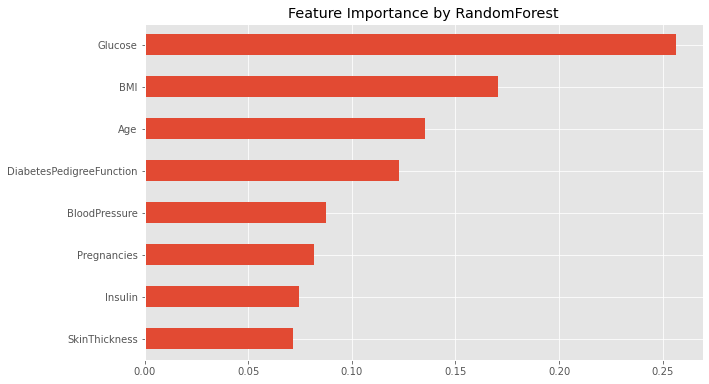

In [13]:
from sklearn.ensemble import RandomForestClassifier

# 创建分类器
model = RandomForestClassifier(random_state=123)

# 拟合数据
model.fit(X, y)

# 提取特征重要性
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance.sort_values()

# 可视化
ax = importance.plot.barh(figsize = (10, 6.18), title="Feature Importance by RandomForest")

上图显示，最重要的3个特征分别是'Glucose','BMI','Age'，这都包含在单变量选择和递归消除的结果中。

## 4. PCA

PCA(Principle Component Analysis): 主成分分析。

PCA是一种降维技术(dimension reduction)，属于无监督机器学习算法，也可用于特征选择。

PCA的核心原理是将大量的相关变量转化为几组无关变量，这些无关变量称为主成分，它们能够保留原始数据的大部分变异。

拟合PCA模型前要先选择约简的维数，这个步骤带有主观判断，如果对问题和数据集缺乏深入理解，很难做出一个正确的选择，当然可以用数学技巧解决这个问题。

接下来用sklearn实现PCA。

In [14]:
from sklearn.decomposition import PCA

# 创建PCA对象，选择3个主成分
pca = PCA(n_components=3)

# 提取主成分
# PCA是无监督机器学习算法，不需要提供目标变量
res = pca.fit_transform(X)

# 获取总的解释方差比率
total_evr = np.sum(pca.explained_variance_ratio_)

# 查看结果
print(f"original features: {X.shape}")
print(f"transform features: {res.shape}")
print(f"explained variance ratio: {total_evr * 100:.2f}%")
print(res)

original features: (768, 8)
transform features: (768, 3)
explained variance ratio: 97.59%
[[-75.71465491 -35.95078264  -7.26078895]
 [-82.3582676   28.90821322  -5.49667139]
 [-74.63064344 -67.90649647  19.46180812]
 ...
 [ 32.11319827   3.3766648   -1.58786446]
 [-80.21449431 -14.18601977  12.3512639 ]
 [-81.30814972  21.62149606  -8.15276833]]


调用pca.fit_transform得到一个(n_samples, n_components)的数组，每一列都代表一个主成分，它们是原始特征的线性组合。

这个数组就是新的"特征矩阵"。

用PCA做特征选择的好处在于，能够创建几个"新特征"来代替数十个原始特征，数据集的维度大大降低，这些新特征不仅能够包含原始数据的大部分变异(方差)，而且彼此间不相关。

缺点是无法从经济意义上解读"新特征"，因为每个主成分都是原始特征的线性组合，从上面的数组就可以看出，它们与原始特征完全不同。